# **Personal AI Assistant Chatbot**

**Yahyaa Chammami**

# **Introduction**



At times, we all experience moments when we feel overwhelmed, anxious, or simply in need of someone to talk to. However, there are instances when we find ourselves unable to access the support we need, whether due to geographical distance, time constraints, or the fear of judgment. This can make the journey toward mental well-being feel even more isolating.

Recognizing this challenge, I created an **AI-based mental health chatbot** designed to offer immediate, compassionate support. The chatbot aims to provide a safe, accessible space where users can engage in confidential conversations and receive guidance on managing their emotions, stress, and mental health. While it cannot replace professional help, it serves as an initial step toward understanding, coping, and finding the right support when needed most.

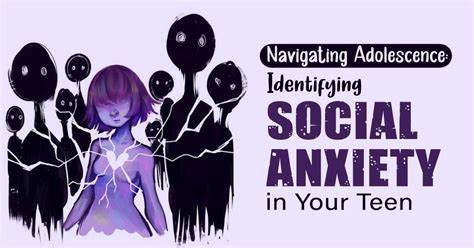

## Install the requirment libraries

In [ ]:
!pip install datasets transformers datasets trl peft accelerate bitsandbytes --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00


In [ ]:
pip install --upgrade transformers

In [ ]:
import pandas as pd
import re
from datasets import Dataset
import datasets
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
from datasets import load_dataset
from random import randrange
#from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,TrainingArguments,pipeline
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model, AutoPeftModelForCausalLM
from trl import SFTTrainer
#from huggingface_hub import login, notebook_login

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
print (device)

cuda


## Read Dataset

In [ ]:
# Read the CSV file
df = pd.read_csv('dataframe.csv')[["patterns", "responses"]]
df[225:235]

,patterns,responses
225,What causes mental health problems?,['Challenges or problems with your mental heal...
226,What do I do if I'm worried about my mental he...,['The most important thing is to talk to someo...
227,How do I know if I'm unwell?,"['If your beliefs , thoughts , feelings or beh..."
228,How can I maintain social connections? What if...,"[""A lot of people are alone right now, but we ..."
229,What's the difference between anxiety and stress?,"[""Stress and anxiety are often used interchang..."
230,What's the difference between sadness and depr...,"[""Sadness is a normal reaction to a loss, disa..."
231,difference between sadness and depression,"[""Sadness is a normal reaction to a loss, disa..."


**About this dataset :**

This dataset contains a compilation of carefully-crafted Q&A pairs which are designed to provide AI-based tailored support for mental health. These carefully chosen questions and answers offer an avenue for those looking for help to gain the assistance they need. With these pre-processed conversations, Artificial Intelligence (AI) solutions can be developed and deployed to better understand and respond appropriately to individual needs based on their input. This comprehensive dataset is crafted by experts in the mental health field, providing insightful content that will further research in this growing area. These data points will be invaluable for developing the next generation of personalized AI-based mental health chatbots capable of truly understanding what people need

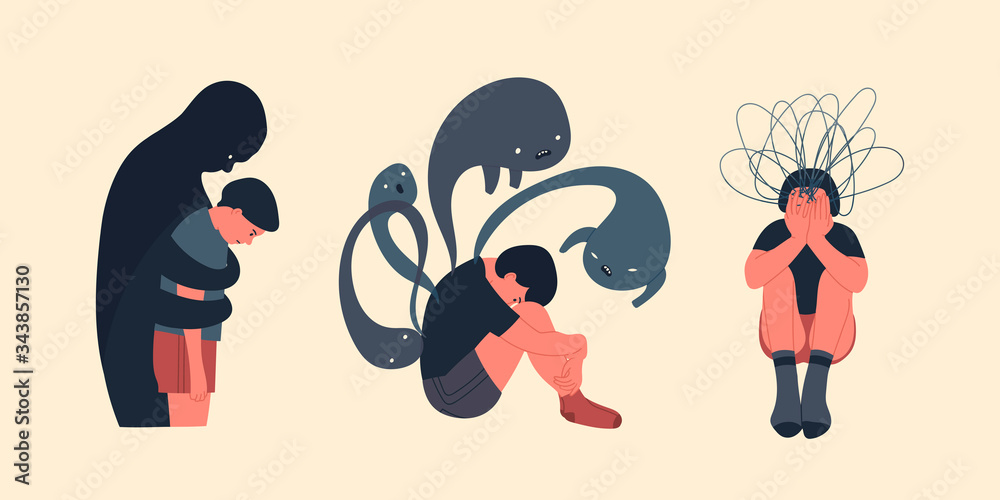

## Clean the Data

In [ ]:
def filter_text(text):
    # Check if the input is a string, if not return an empty string or convert to string
    if isinstance(text, str):
        text = text.lower()
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        return text
    else:
        return ''

In [ ]:
df['patterns'] = df['patterns'].apply(filter_text)
df['responses'] = df['responses'].apply(filter_text)
df.head()

,patterns,responses
0,hi,hello there tell me how are you feeling today...
1,hey,hello there tell me how are you feeling today...
2,is anyone there,hello there tell me how are you feeling today...
3,hi there,hello there tell me how are you feeling today...
4,hello,hello there tell me how are you feeling today...


## Split train, test and validate

In [ ]:
train= df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test= df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

print("Training Shape: ", train.shape)
print("Validation Shape: ", val.shape)
print("Testing Shape: ", test.shape)

Training Shape:  (162, 2)
Validation Shape:  (35, 2)
Testing Shape:  (35, 2)


## Load Model and Tokenizer

**Google’s T5 Transformer model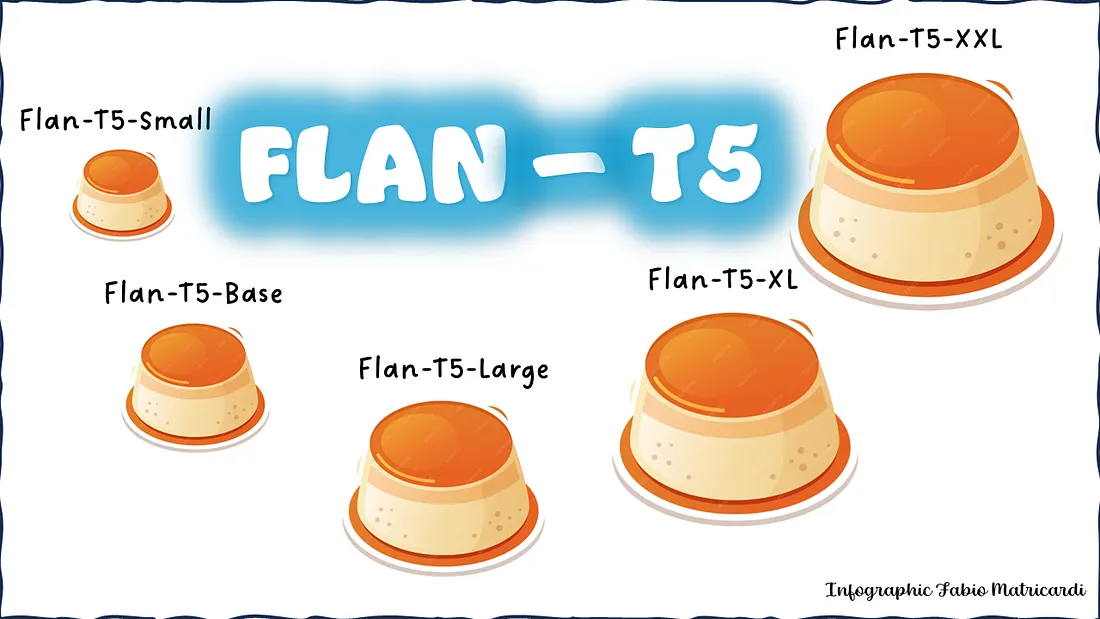**

In [ ]:
def get_model_tokenizer(model_name = "google/flan-t5-base"):
  original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.float32)
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  return original_model, tokenizer

In [ ]:
model, tokenizer = get_model_tokenizer()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

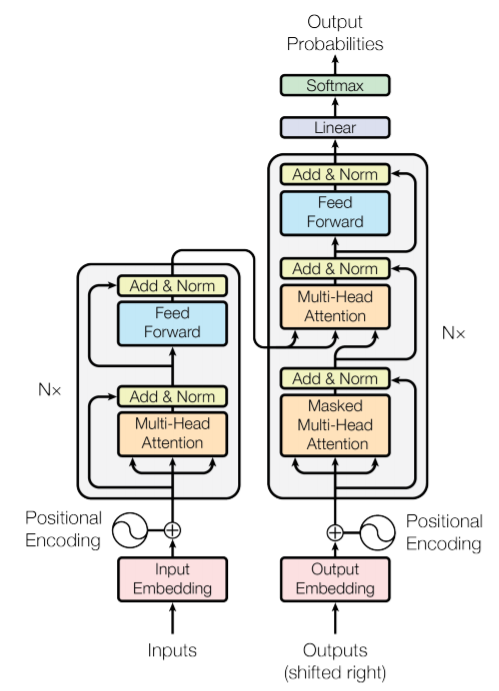

## Prompt Engineering

In [ ]:
def tokenize_function(example):
    start_prompt = 'You are an AI assistant. Your task is to carefully follow the next question and generate insightful answers or practical advice Focus on providing helpful, well-informed guidance or solutions.\n\n'
    end_prompt = '\n\nAnswer: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["patterns"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt", max_length=200).input_ids
    example['labels'] = tokenizer(example["responses"], padding="max_length", truncation=True, return_tensors="pt",max_length=200).input_ids

    return example

In [ ]:
# Tokenize train set

train_data = Dataset.from_pandas(train)
train_tokenized_datasets = train_data.map(tokenize_function, batched=True)
train_tokenized_datasets = train_tokenized_datasets.remove_columns(['patterns', 'responses',])

# Tokenize validation set

val_data = Dataset.from_pandas(val)
val_tokenized_datasets = val_data.map(tokenize_function, batched=True)
val_tokenized_datasets = val_tokenized_datasets.remove_columns(['patterns', 'responses',])

# Tokenize test set

test_data = Dataset.from_pandas(test)
test_tokenized_datasets = test_data.map(tokenize_function, batched=True)
test_tokenized_datasets = test_tokenized_datasets.remove_columns(['patterns', 'responses',])

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

## Train the model

To address this gap, I created an AI-based mental health chatbot using advanced techniques like **LoRa (Low-Rank Adaptation)** and **SFTtrainer (Supervised Fine-Tuning Trainer)**.

These technologies allow the model to adapt more efficiently and accurately to the specific needs of users, providing a highly personalized experience while remaining resource-efficient.


##### **LoRa (Low-Rank Adaptation)**
**When Use LoRA:**

Low-Rank Adaptation, or LoRA, which freezes the pre-trained model weights and injects trainable rank decomposition matrices into each layer of the Transformer architecture, greatly reducing the number of trainable parameters by 10,000 times and the GPU memory requirement by 3 times.


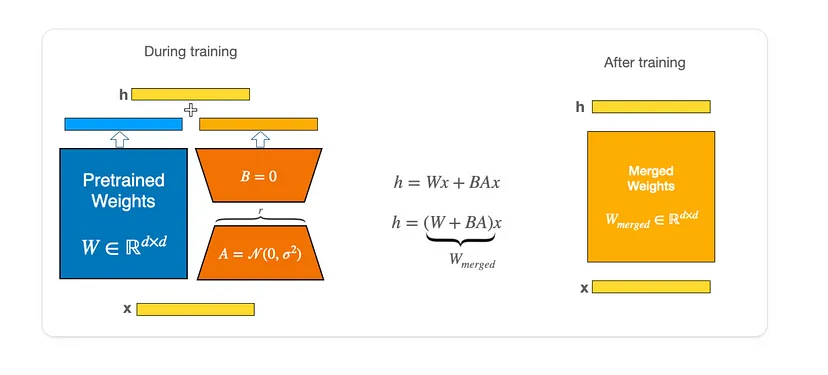

##### **SFTTrainer**
**When Use SFTTrainer:**

If you have a pre-trained model and a relatively smaller dataset, and want a simpler and faster fine-tuning experience with efficient memory usage.

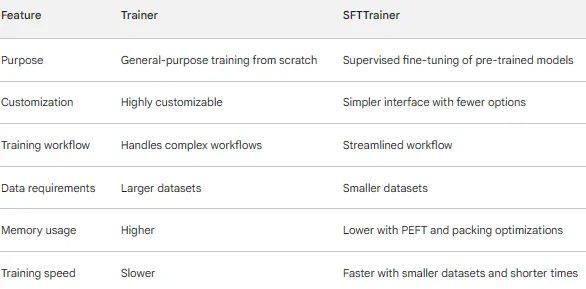

In [ ]:
# Create the trainer

training_path = "./training_path_ai_chatbot"

trainingArgs = TrainingArguments(
    output_dir= training_path,
    num_train_epochs=10,
    per_device_train_batch_size=4,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-4
)

peft_config = LoraConfig(
      lora_alpha=16,
      lora_dropout=0.1,
      r=64,
      bias="none",
      task_type="CAUSAL_LM",
)

trainer1 = SFTTrainer(
    model=model,
    train_dataset=train_tokenized_datasets,
    eval_dataset = val_tokenized_datasets,
    peft_config=peft_config,
    tokenizer=tokenizer,
    packing=True,
    args=trainingArgs,
)

trainer1.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': packing. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:195: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
 

Epoch,Training Loss,Validation Loss
1,No log,22.284019
2,No log,5.024470
3,No log,4.273233
4,No log,4.017290
5,No log,3.511694
6,No log,2.694129
7,No log,1.981641
8,No log,1.643343
9,No log,1.558501
10,No log,1.535389


TrainOutput(global_step=410, training_loss=7.405035846989329, metrics={'train_runtime': 162.8368, 'train_samples_per_second': 9.949, 'train_steps_per_second': 2.518, 'total_flos': 447082426368000.0, 'train_loss': 7.405035846989329, 'epoch': 10.0})

In [ ]:

model_path = "./ai-chatbot-final-model"

trainer1.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('./ai-chatbot-final-model/tokenizer_config.json',
 './ai-chatbot-final-model/special_tokens_map.json',
 './ai-chatbot-final-model/spiece.model',
 './ai-chatbot-final-model/added_tokens.json',
 './ai-chatbot-final-model/tokenizer.json')

In [ ]:
pip install evaluate rouge_score --quiet

## Use the trained model

In [ ]:
test_text = "I am not feeling good what should i do"

start_prompt = "You are an AI assistant. Your task is to carefully follow the next question and generate insightful answers or practical advice Focus on providing helpful, well-informed guidance or solutions.\n\n"
end_prompt = "\nAnswer:\n\n"
full_prompt = start_prompt + test_text + end_prompt

print(full_prompt)

You are an AI assistant. Your task is to carefully follow the next question and generate insightful answers or practical advice Focus on providing helpful, well-informed guidance or solutions.

I am not feeling good what should i do
Answer:




In [ ]:

trained_model = AutoModelForSeq2SeqLM.from_pretrained(model_path, torch_dtype=torch.float32).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path )

tokenized_test_text = tokenizer(full_prompt, return_tensors='pt').input_ids.to(device)
model_output = trained_model.generate(tokenized_test_text, generation_config = GenerationConfig(max_new_tokens = 150))[0]

final_output = tokenizer.decode(model_output, skip_special_tokens = True)
print(final_output)

I should try to get some sleep.


## Evaluate the Model

In [ ]:
eval_results= trainer1.evaluate(eval_dataset = test_tokenized_datasets,)
print(eval_results)

**It's a text generation model, and we can't reliably judge its performance based solely on loss or accuracy. Therefore, we need to use ROUGE and BLEU scores to evaluate its output.**

#####**BLEU/ROUGE scores:**

**BLEU (Bilingual Evaluation Understudy)** and **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** scores are used to evaluate the quality of generated text by comparing it to reference texts.

In [ ]:
import evaluate

# Load the ROUGE metric
rouge = evaluate.load('rouge')
bleu = evaluate.load("bleu")

predictions = ["How can I reduce anxiety?", "What are the symptoms of depression?", "How can I manage stress?"]
references = ["Practice deep breathing and mindfulness exercises to help reduce anxiety.",
              "Common symptoms of depression include persistent sadness, loss of interest in activities, and changes in sleep or appetite.",
              "Effective stress management techniques include time management, exercise, and relaxation techniques."]

# Compute ROUGE score
results1 = rouge.compute(predictions=predictions, references=references)
# Compute the BLEU score
results2 = bleu.compute(predictions=predictions, references=references)


ROUGE Scores: {'rouge1': 1.0, 'rouge2': 0.3333333333333333, 'rougeL': 1.0, 'rougeLsum': 1.0}
------------------------------
BLUE Scores: {'bleu': 0.0, 'precisions': [1.0, 1.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 4, 'reference_length': 4}


In [ ]:
# Print results
print("ROUGE Scores:", results1)
print('')
print("------------------------------")
print('')
print("BLUE Scores:", results2)

ROUGE Scores: {'rouge1': 1.0, 'rouge2': 0.3333333333333333, 'rougeL': 1.0, 'rougeLsum': 1.0}

------------------------------

BLUE Scores: {'bleu': 0.0, 'precisions': [1.0, 1.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 4, 'reference_length': 4}


## Bibliography

- **Google’s T5 Transformer model, HaggingFace** https://huggingface.co/google-t5/t5-base .


- **LoRA: Low-Rank Adaptation of Large Language Models Paper** by Edward J. Hu, Yelong Shen, Phillip Wallis, Zeyuan Allen-Zhu, Yuanzhi Li, Shean Wang, Lu Wang, Weizhu Chen. https://arxiv.org/abs/2106.09685 .


- **LoRa Github repo by Microsoft** https://github.com/microsoft/LoRA .


- **Supervised Fine-tuning Trainer Hagging face** https://huggingface.co/docs/trl/main/en/sft_trainer .


- **Supervised Fine-tuning: customizing LLMs** by Juan Martinez https://medium.com/mantisnlp/supervised-fine-tuning-customizing-llms-a2c1edbf22c3


